The key point of this kernel is the NN output gaussian distirbution directly described as the following.
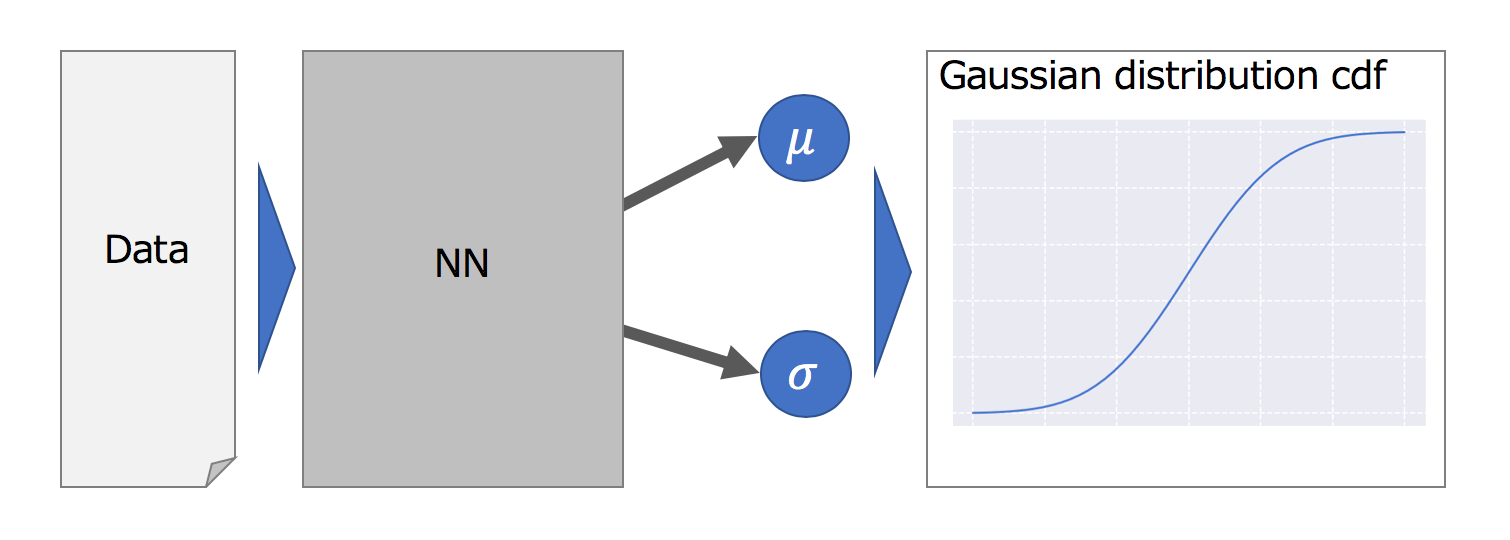

The original kernel is [this](https://www.kaggle.com/mrkmakr/neural-network-with-mae-objective-0-01381). I just change the last part of the network to output distribution using `GaussianLayer` as a custom layer. 

 ```
 class GaussianLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(GaussianLayer, self).build(input_shape) 

    def call(self, x):
        xx = K.arange(-99, 100, dtype=tf.float32)
        sigma = tf.identity(K.exp(0.5 * tf.reshape(x[:, 1], (-1, 1))), name="sigma")
        pdf = 1/(sigma* K.sqrt(2 * tf.constant(m.pi))) * K.exp( -(tf.subtract(xx, tf.reshape(x[:, 0], (-1, 1))))**2 / (2 * sigma**2) )
        return K.cumsum(pdf, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

 ```

In [ ]:
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from tensorflow.python.keras.layers import Lambda

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]


import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# pandas formatting
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
print(train.shape)
train.head()

## Feature engineering

In [ ]:
#https://www.kaggle.com/rooshroosh/fork-of-neural-networks-different-architecture
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"
    

In [ ]:
def preprocess(train):
    ## GameClock
    train['GameClock_sec'] = train['GameClock'].apply(strtoseconds)
    train["GameClock_minute"] = train["GameClock"].apply(lambda x : x.split(":")[0]).astype("object")

    ## Height
    train['PlayerHeight_dense'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

    ## Time
    train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

    train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

    ## Age
    seconds_in_year = 60*60*24*365.25
    train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    train["PlayerAge_ob"] = train['PlayerAge'].astype(np.int).astype("object")

    ## WindSpeed
    train['WindSpeed_ob'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    train['WindSpeed_dense'] = train['WindSpeed_ob'].apply(strtofloat)

    ## Weather
    train['GameWeather_process'] = train['GameWeather'].str.lower()
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    train['GameWeather_dense'] = train['GameWeather_process'].apply(map_weather)

    ## Rusher
    train['IsRusher'] = (train['NflId'] == train['NflIdRusher'])
    train['IsRusher_ob'] = (train['NflId'] == train['NflIdRusher']).astype("object")
    temp = train[train["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    train = train.merge(temp, on = "PlayId")
    train["IsRusherTeam"] = train["Team"] == train["RusherTeam"]

    ## dense -> categorical
    train["Quarter_ob"] = train["Quarter"].astype("object")
    train["Down_ob"] = train["Down"].astype("object")
    train["JerseyNumber_ob"] = train["JerseyNumber"].astype("object")
    train["YardLine_ob"] = train["YardLine"].astype("object")
    # train["DefendersInTheBox_ob"] = train["DefendersInTheBox"].astype("object")
    # train["Week_ob"] = train["Week"].astype("object")
    # train["TimeDelta_ob"] = train["TimeDelta"].astype("object")


    ## Orientation and Dir
    train["Orientation_ob"] = train["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
    train["Dir_ob"] = train["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

    train["Orientation_sin"] = train["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Orientation_cos"] = train["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    train["Dir_sin"] = train["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Dir_cos"] = train["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))

    ## diff Score
    train["diffScoreBeforePlay"] = train["HomeScoreBeforePlay"] - train["VisitorScoreBeforePlay"]
    train["diffScoreBeforePlay_binary_ob"] = (train["HomeScoreBeforePlay"] > train["VisitorScoreBeforePlay"]).astype("object")

    ## Turf
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
    train['Turf'] = train['Turf'].map(Turf)

    ## OffensePersonnel
    temp = train["OffensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(OffensePersonnelSplit(x)))
    temp.columns = ["Offense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")

    ## DefensePersonnel
    temp = train["DefensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(DefensePersonnelSplit(x)))
    temp.columns = ["Defense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")

    ## sort
#     train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index(drop = True)
    train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)
    return train

In [ ]:
%%time
train = preprocess(train)

In [ ]:
## DisplayName remove Outlier
v = train["DisplayName"].value_counts()
missing_values = list(v[v < 5].index)
train["DisplayName"] = train["DisplayName"].where(~train["DisplayName"].isin(missing_values), "nan")

## PlayerCollegeName remove Outlier
v = train["PlayerCollegeName"].value_counts()
missing_values = list(v[v < 10].index)
train["PlayerCollegeName"] = train["PlayerCollegeName"].where(~train["PlayerCollegeName"].isin(missing_values), "nan")

In [ ]:
pd.to_pickle(train, "train.pkl")

In [ ]:
def drop(train):
    drop_cols = ["GameId", "GameWeather", "NflId", "Season", "NflIdRusher"] 
    drop_cols += ['TimeHandoff', 'TimeSnap', 'PlayerBirthDate']
    drop_cols += ["Orientation", "Dir", 'WindSpeed', "GameClock"]
    # drop_cols += ["DefensePersonnel","OffensePersonnel"]
    train = train.drop(drop_cols, axis = 1)
    return train

In [ ]:
train = drop(train)

In [ ]:
cat_features = []
dense_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append(col)
        print("*cat*", col, len(train[col].unique()))
    else:
        dense_features.append(col)
        print("!dense!", col, len(train[col].unique()))
dense_features.remove("PlayId")
dense_features.remove("Yards")

## categorical

In [ ]:
train_cat = train[cat_features]
categories = []
most_appear_each_categories = {}
for col in tqdm_notebook(train_cat.columns):
    train_cat.loc[:,col] = train_cat[col].fillna("nan")
    train_cat.loc[:,col] = col + "__" + train_cat[col].astype(str)
    most_appear_each_categories[col] = list(train_cat[col].value_counts().index)[0]
    categories.append(train_cat[col].unique())
categories = np.hstack(categories)
print(len(categories))

In [ ]:
le = LabelEncoder()
le.fit(categories)
for col in tqdm_notebook(train_cat.columns):
    train_cat.loc[:, col] = le.transform(train_cat[col])
num_classes = len(le.classes_)

## Dense

In [ ]:
train_dense = train[dense_features]
sss = {}
medians = {}
for col in tqdm_notebook(train_dense.columns):
    print(col)
    medians[col] = np.nanmedian(train_dense[col])
    train_dense.loc[:, col] = train_dense[col].fillna(medians[col])
    ss = StandardScaler()
    train_dense.loc[:, col] = ss.fit_transform(train_dense[col].values[:,None])
    sss[col] = ss

## Divide features into groups

In [ ]:
## dense features for play
dense_game_features = train_dense.columns[train_dense[:22].std() == 0]
## dense features for each player
dense_player_features = train_dense.columns[train_dense[:22].std() != 0]
## categorical features for play
cat_game_features = train_cat.columns[train_cat[:22].std() == 0]
## categorical features for each player
cat_player_features = train_cat.columns[train_cat[:22].std() != 0]

In [ ]:
train_dense_game = train_dense[dense_game_features].iloc[np.arange(0, len(train), 22)].reset_index(drop = True).values
train_dense_game = np.hstack([train_dense_game, train_dense[dense_player_features][train_dense["IsRusher"] > 0]]) ## with rusher player feature

train_dense_players = [train_dense[dense_player_features].iloc[np.arange(k, len(train), 22)].reset_index(drop = True) for k in range(22)]
train_dense_players = np.stack([t.values for t in train_dense_players]).transpose(1, 0, 2)

train_cat_game = train_cat[cat_game_features].iloc[np.arange(0, len(train), 22)].reset_index(drop = True).values
train_cat_game = np.hstack([train_cat_game, train_cat[cat_player_features][train_dense["IsRusher"] > 0]]) ## with rusher player feature

train_cat_players = [train_cat[cat_player_features].iloc[np.arange(k, len(train), 22)].reset_index(drop = True) for k in range(22)]
train_cat_players = np.stack([t.values for t in train_cat_players]).transpose(1, 0, 2)

In [ ]:
def return_step(x):
    temp = np.zeros(199)
    temp[x + 99:] = 1
    return temp

train_y_raw = train["Yards"].iloc[np.arange(0, len(train), 22)].reset_index(drop = True)
train_y = np.vstack(train_y_raw.apply(return_step).values)

In [ ]:
train_dense_game.shape, train_dense_players.shape, train_cat_game.shape, train_cat_players.shape, train_y.shape

## Model

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
keras.backend.clear_session()
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint

def crps(y_true, y_pred):
    loss = K.mean((y_pred - y_true)**2)
    return loss

from keras.engine.topology import Layer
class GaussianLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(GaussianLayer, self).build(input_shape) 

    def call(self, x):
        xx = K.arange(-99, 100, dtype=tf.float32)
        sigma = tf.identity(K.exp(0.5 * tf.reshape(x[:, 1], (-1, 1))), name="sigma")
        pdf = 1/(sigma* K.sqrt(2 * tf.constant(m.pi))) * K.exp( -(tf.subtract(xx, tf.reshape(x[:, 0], (-1, 1))))**2 / (2 * sigma**2) )
        return K.cumsum(pdf, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model
    
def get_model(n_iter, fold_, batch_size = 32, epochs = 10):
    activation = "relu"
    ## inputs
    input_dense_game = keras.layers.Input(shape=(train_dense_game.shape[1],), name = "numerical_general_inputs")
    input_dense_players = keras.layers.Input(shape=(train_dense_players.shape[1],train_dense_players.shape[2]), name = "numerical_players_inputs")
    input_cat_game = keras.layers.Input(shape=(train_cat_game.shape[1], ), name = "categorical_general_inputs")
    input_cat_players = keras.layers.Input(shape=(train_cat_players.shape[1], train_cat_players.shape[2]), name = "categorical_players_input")
    
    ## embedding
    embedding = keras.layers.Embedding(num_classes, 4, embeddings_regularizer=regularizers.l2(1e-4))
    emb_cat_game = embedding(input_cat_game)
    emb_cat_game = keras.layers.Flatten()(emb_cat_game)
    emb_cat_players = embedding(input_cat_players)
    emb_cat_players = keras.layers.Reshape((int(emb_cat_players.shape[1]), int(emb_cat_players.shape[2]) * int(emb_cat_players.shape[3])))(emb_cat_players)
    
    ## general game features
    game = keras.layers.Concatenate(name = "general_features")([input_dense_game, emb_cat_game])
    game = keras.layers.Dense(32, activation=activation)(game)
    game = keras.layers.Dropout(0.5)(game)
    
    ## players features
    players = keras.layers.Concatenate(name = "players_features")([input_dense_players, emb_cat_players])
    n_unit = 16
    players_aves = []
    for k in range(3):
        players = keras.layers.Dense(n_unit, activation=None)(players)
        players_aves.append(keras.layers.GlobalAveragePooling1D()(players))
        players = keras.layers.Activation(activation)(players)
    players = keras.layers.Concatenate(name = "deep_players_features")(players_aves)
    players = keras.layers.Dropout(0.5)(players)

    ### concat all
    x_concat = keras.layers.Concatenate(name = "general_and_players")([game, players])
    x_concats = []
    n_unit = 128
    decay_rate = 0.5
    for k in range(3):
        x_concat = keras.layers.Dense(n_unit, activation=activation)(x_concat)
        x_concats.append(x_concat)
        n_unit = int(n_unit * decay_rate)
    x_concat = keras.layers.Concatenate(name = "deep_features")(x_concats)
    x_concat = keras.layers.Dropout(0.5)(x_concat)
    
    ## concat
    x_concat = keras.layers.Concatenate(name = "all_concat")([game, players, x_concat])
    
    x_concat = keras.layers.Dense(128, activation=activation, name = "last_dense1")(x_concat)
    x_concat = keras.layers.Dropout(0.5)(x_concat)
    x_concat = keras.layers.Dense(64, activation=activation, name = "last_dense2")(x_concat)
    x_concat = keras.layers.Dropout(0.2)(x_concat)
    x_concat = keras.layers.Dense(32, activation=activation, name = "last_dense3")(x_concat)
    mu_log_var = keras.layers.Dense(2, activation="linear", name = "mu_log_var")(x_concat)
    out_dist = GaussianLayer(output_dim=199)(mu_log_var)
    model = keras.models.Model(inputs = [input_dense_game, input_dense_players, input_cat_game, input_cat_players],
                               outputs = out_dist)
    print(model)
    ## compile
    model.compile(loss=crps, optimizer=keras.optimizers.Adam(learning_rate=0.002, decay = 1e-4))

    ## train
    tr_x = [train_dense_game[tr_inds], train_dense_players[tr_inds], train_cat_game[tr_inds], train_cat_players[tr_inds]]
    tr_y = train_y[tr_inds]
    val_x = [train_dense_game[val_inds], train_dense_players[val_inds], train_cat_game[val_inds], train_cat_players[val_inds]]
    val_y = train_y[val_inds]
    
    save_model_name = f'model_{fold_}.h5'
    print(save_model_name)
    modelCheckpoint = ModelCheckpoint(filepath = save_model_name,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)
    
    model.fit(tr_x,
              tr_y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(val_x, val_y), callbacks=[modelCheckpoint])
    loss = model.history.history["val_loss"][-1]
    model = getNewestModel(model, save_model_name)
    return model, loss

In [ ]:
import os
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
losses = []
models = []
for k in range(2):
    #kfold = KFold(5, random_state = 42 + k, shuffle = True)
    kfold = StratifiedKFold(5, random_state = 42 + k, shuffle = True)
    for fold_, (tr_inds, val_inds) in enumerate(kfold.split(train_y_raw, train_y_raw)):
        print(f"----- fold:{fold_} ------")
        print("--------------------------")
        model, loss = get_model(k, fold_, 32, 20)
        models.append(model)
        print(fold_, loss)
        losses.append(loss)
print("-------")
print(losses)
print(np.mean(losses))

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
print(losses)
print(np.mean(losses))

## Prediction

In [ ]:
def make_pred(test, sample, env, model):
    test = preprocess(test)
    test = drop(test)

    ### categorical
    test_cat = test[cat_features]
    for col in (test_cat.columns):
        test_cat.loc[:,col] = test_cat[col].fillna("nan")
        test_cat.loc[:,col] = col + "__" + test_cat[col].astype(str)
        isnan = ~test_cat.loc[:,col].isin(categories)
        if np.sum(isnan) > 0:
#             print("------")
#             print("test have unseen label : col")
            if not ((col + "__nan") in categories):
#                 print("not nan in train : ", col)
                test_cat.loc[isnan,col] = most_appear_each_categories[col]
            else:
#                 print("nan seen in train : ", col)
                test_cat.loc[isnan,col] = col + "__nan"
    for col in (test_cat.columns):
        test_cat.loc[:, col] = le.transform(test_cat[col])

    ### dense
    test_dense = test[dense_features]
    for col in (test_dense.columns):
        test_dense.loc[:, col] = test_dense[col].fillna(medians[col])
        test_dense.loc[:, col] = sss[col].transform(test_dense[col].values[:,None])

    ### divide
    test_dense_players = [test_dense[dense_player_features].iloc[np.arange(k, len(test), 22)].reset_index(drop = True) for k in range(22)]
    test_dense_players = np.stack([t.values for t in test_dense_players]).transpose(1,0, 2)

    test_dense_game = test_dense[dense_game_features].iloc[np.arange(0, len(test), 22)].reset_index(drop = True).values
    test_dense_game = np.hstack([test_dense_game, test_dense[dense_player_features][test_dense["IsRusher"] > 0]])
    
    test_cat_players = [test_cat[cat_player_features].iloc[np.arange(k, len(test), 22)].reset_index(drop = True) for k in range(22)]
    test_cat_players = np.stack([t.values for t in test_cat_players]).transpose(1,0, 2)

    test_cat_game = test_cat[cat_game_features].iloc[np.arange(0, len(test), 22)].reset_index(drop = True).values
    test_cat_game = np.hstack([test_cat_game, test_cat[cat_player_features][test_dense["IsRusher"] > 0]])

    test_inp = [test_dense_game, test_dense_players, test_cat_game, test_cat_players]
    
    ## pred
    pred = 0
    for model in models:
        _pred = model.predict(test_inp)
        #_pred = np.cumsum(_pred, axis = 1)
        pred += _pred
    pred /= len(models)
    pred = np.clip(pred, 0, 1)
    env.predict(pd.DataFrame(data=pred,columns=sample.columns))
    return pred

In [ ]:
env = nflrush.make_env()
preds = []
for test, sample in tqdm_notebook(env.iter_test()):
    pred = make_pred(test, sample, env, models)
    preds.append(pred)
env.write_submission_file()

In [ ]:
preds = np.vstack(preds)
## check whether prediction is submittable
print(np.mean(np.diff(preds, axis = 1) >= 0) == 1.0)
print(np.mean(preds > 1) == 0)

In [ ]:
print(losses)
print(np.mean(losses))